### Resource
##### https://www.kaggle.com/kmader/dsb-lung-segmentation-algorithm

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border, mark_boundaries
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
from glob import glob
from skimage.io import imread
BASE_IMG_PATH=os.path.join('..','input')

In [2]:
all_images = glob(os.path.join(BASE_IMG_PATH,'2d_images','*.tif'))
all_masks = ['_masks'.join(c_file.split('_images')) for c_file in all_images]
print(len(all_masks),' matching files found')

267  matching files found


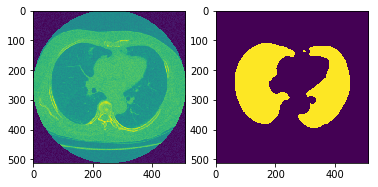

In [4]:
%matplotlib inline
test_image=imread(all_images[4])
test_mask=imread(all_masks[4])
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(test_image)
ax2.imshow(test_mask)

In [17]:
def get_segmented_lungs(raw_im, plot=False):
    '''
    Original function changes input image (ick!)
    '''
    im=raw_im.copy()
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < -400
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
   
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
        
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return binary

6


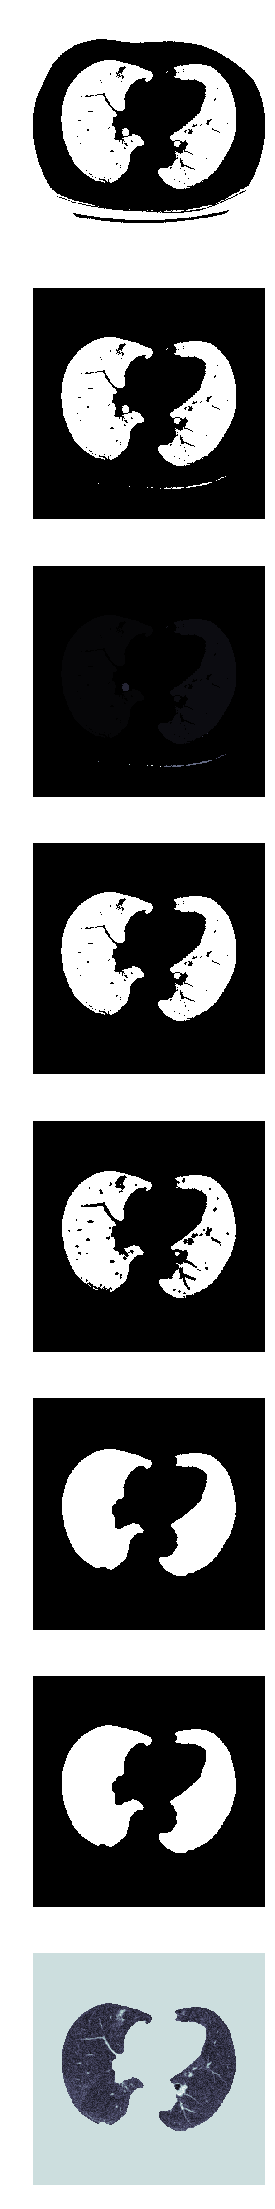

In [18]:
test_seg=get_segmented_lungs(test_image,True)

Text(0.5,1,'Difference')

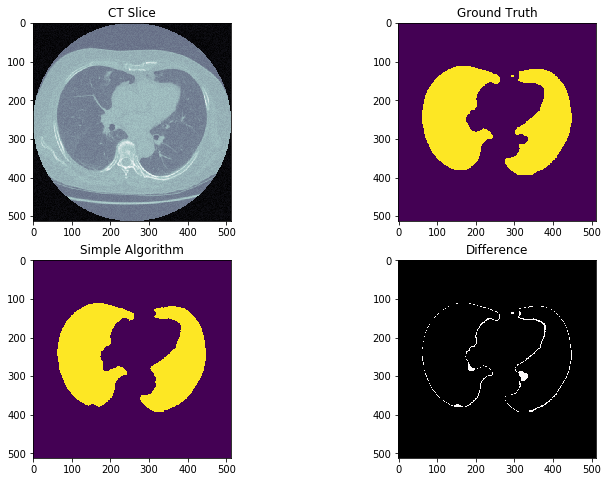

In [21]:
%matplotlib inline
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,8))
ax1.imshow(test_image,cmap='bone')
ax1.set_title('CT Slice')
ax2.imshow(test_mask)
ax2.set_title('Ground Truth')
ax3.imshow(test_seg)
ax3.set_title('Simple Algorithm')
ax4.imshow((test_seg>0)^(test_mask>0),cmap='gist_earth')
ax4.set_title('Difference')

In [22]:
from sklearn.metrics import roc_curve, auc, classification_report # roc curve tools
print(classification_report(y_pred=test_seg.ravel()>0,y_true=test_mask.ravel()>0))


             precision    recall  f1-score   support

      False       0.98      1.00      0.99    201812
       True       0.99      0.94      0.97     60332

avg / total       0.99      0.99      0.99    262144



# Show Segmentation
#####  The ground truth (green) and the prediction (red) 

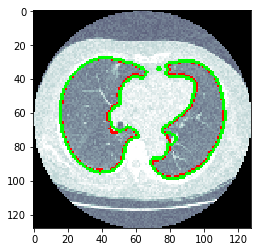

In [23]:
def make_mb_image(i_img, i_gt, i_pred,ds_op=lambda x: x[::4,::4]):
    n_img = (i_img-i_img.mean())/(2*i_img.std())+0.5
    c_img = plt.cm.bone(n_img)[:,:,:3]
    c_img=mark_boundaries(ds_op(c_img),label_img=ds_op(i_pred), color = (1,0,0),mode='thick')
    c_img=mark_boundaries(c_img,label_img=ds_op(i_gt),color=(0,1,0),mode='thick|')
    return c_img

plt.imshow(make_mb_image(test_image, test_mask, test_seg))

In [24]:
from sklearn.metrics import f1_score
pred_output=[]
f1_scores=[]
for i_path, m_path in zip(all_images,all_masks):
    n_img=imread(i_path)
    n_mask=imread(m_path)
    p_mask=get_segmented_lungs(n_img)
    f1_scores+=[f1_score(y_pred=p_mask.ravel()>0,y_true=n_mask.ravel()>0)]
    pred_output+=[make_mb_image(n_img, n_mask, p_mask)]

Text(0.5,1,'Worst Score 0.47')

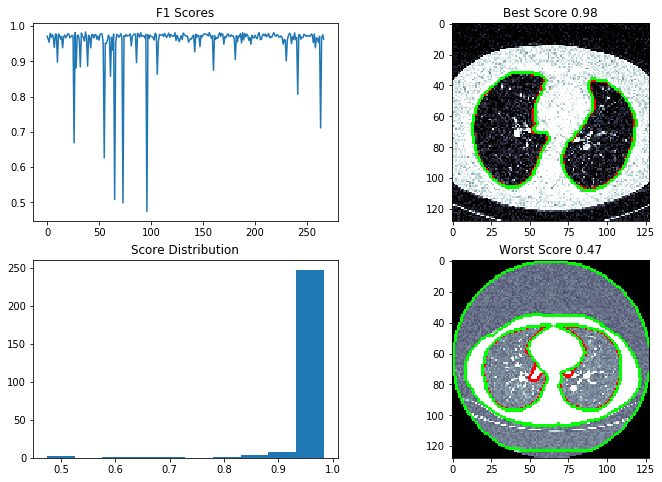

In [25]:
fig, ((ax_score,ax_best),(ax_hist,ax_worst)) = plt.subplots(2,2,figsize=(12,8))
ax_score.plot(f1_scores)
ax_score.set_title('F1 Scores')
ax_hist.hist(f1_scores)
ax_hist.set_title('Score Distribution')
ax_best.imshow(pred_output[np.argmax(f1_scores)])
ax_best.set_title('Best Score %2.2f' % np.max(f1_scores))
ax_worst.imshow(pred_output[np.argmin(f1_scores)])
ax_worst.set_title('Worst Score %2.2f' % np.min(f1_scores))

## Output all Results

/home/sara/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


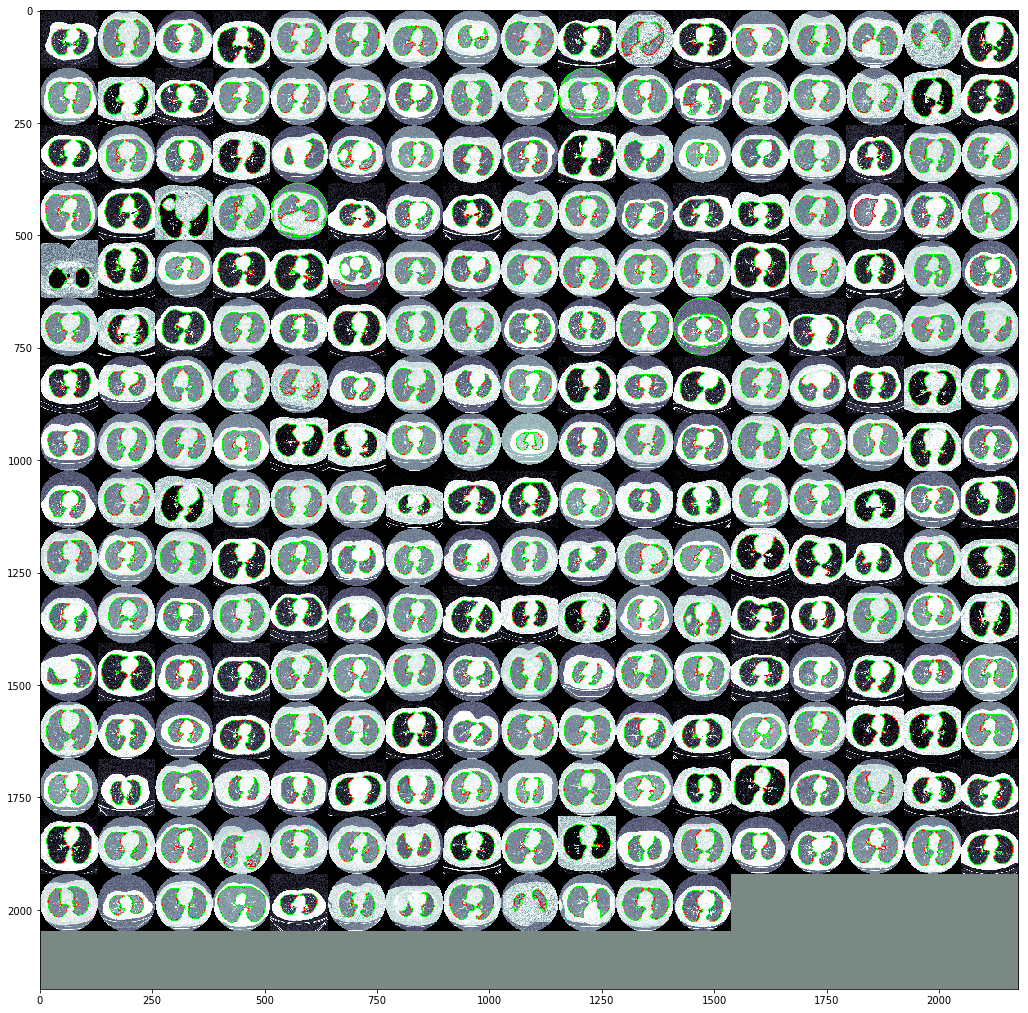

In [29]:
fig = plt.subplots(1,1,figsize = (18,18))

from skimage.util.montage import montage2d
from skimage.io import imsave
out_montage = []
for i in range(3):
    out_montage += [montage2d(np.stack([i_img[:,:,i] for i_img in pred_output],0))]
out_montage = np.stack(out_montage,-1)
plt.imshow(out_montage)
imsave('all_outputs.jpg',out_montage)